##Mounting the storage point

In [0]:
# Retrieve secrets from Databricks secret scope
service_credential = dbutils.secrets.get(scope="my-scope", key="service-credential")
client_id = dbutils.secrets.get(scope="my-scope", key="client-id")
tenant_id = dbutils.secrets.get(scope="my-scope", key="tenant-id")

# Set up the Spark configuration for Azure Data Lake Storage Gen2
spark.conf.set("fs.azure.account.auth.type.destorageaccount11.dfs.core.windows.net", "OAuth")
spark.conf.set("fs.azure.account.oauth.provider.type.destorageaccount11.dfs.core.windows.net", "org.apache.hadoop.fs.azurebfs.oauth2.ClientCredsTokenProvider")
spark.conf.set("fs.azure.account.oauth2.client.id.destorageaccount11.dfs.core.windows.net", client_id)
spark.conf.set("fs.azure.account.oauth2.client.secret.destorageaccount11.dfs.core.windows.net", service_credential)
spark.conf.set("fs.azure.account.oauth2.client.endpoint.destorageaccount11.dfs.core.windows.net", f"https://login.microsoftonline.com/{tenant_id}/oauth2/token")

# Mount raw-data container
dbutils.fs.mount(
    source="abfss://raw-data@destorageaccount11.dfs.core.windows.net/",
    mount_point="/mnt/raw-data",
    extra_configs={
        "fs.azure.account.auth.type": "OAuth",
        "fs.azure.account.oauth.provider.type": "org.apache.hadoop.fs.azurebfs.oauth2.ClientCredsTokenProvider",
        "fs.azure.account.oauth2.client.id": client_id,
        "fs.azure.account.oauth2.client.secret": service_credential,
        "fs.azure.account.oauth2.client.endpoint": f"https://login.microsoftonline.com/{tenant_id}/oauth2/token"
    }
)

# Mount cleansed-data container
dbutils.fs.mount(
    source="abfss://cleansed-data@destorageaccount11.dfs.core.windows.net/",
    mount_point="/mnt/cleansed-data",
    extra_configs={
        "fs.azure.account.auth.type": "OAuth",
        "fs.azure.account.oauth.provider.type": "org.apache.hadoop.fs.azurebfs.oauth2.ClientCredsTokenProvider",
        "fs.azure.account.oauth2.client.id": client_id,
        "fs.azure.account.oauth2.client.secret": service_credential,
        "fs.azure.account.oauth2.client.endpoint": f"https://login.microsoftonline.com/{tenant_id}/oauth2/token"
    }
)

# Mount confirmed-data container
dbutils.fs.mount(
    source="abfss://confirmed-data@destorageaccount11.dfs.core.windows.net/",
    mount_point="/mnt/confirmed-data",
    extra_configs={
        "fs.azure.account.auth.type": "OAuth",
        "fs.azure.account.oauth.provider.type": "org.apache.hadoop.fs.azurebfs.oauth2.ClientCredsTokenProvider",
        "fs.azure.account.oauth2.client.id": client_id,
        "fs.azure.account.oauth2.client.secret": service_credential,
        "fs.azure.account.oauth2.client.endpoint": f"https://login.microsoftonline.com/{tenant_id}/oauth2/token"
    }
)

True

##Reading Raw Data

In [0]:
# Reading the CSV files from the raw data folder
medals_df = spark.read.csv("/mnt/raw-data/Medals.csv", header=True, inferSchema=True)
entries_gender_df = spark.read.csv("/mnt/raw-data/EntriesGender.csv", header=True, inferSchema=True)
coaches_df = spark.read.csv("/mnt/raw-data/Coaches.csv", header=True, inferSchema=True)
athletes_df = spark.read.csv("/mnt/raw-data/Athletes.csv", header=True, inferSchema=True)
team_df = spark.read.csv("/mnt/raw-data/Teams.csv", header=True, inferSchema=True)


##Data Cleaning

In [0]:
# Removing duplicates and handling missing values, then renaming columns for consistency
athletes_df = athletes_df.dropDuplicates().fillna({'Country': 'Unknown', 'Discipline': 'Unknown'}).withColumnRenamed('Country', 'AthleteCountry')
coaches_df = coaches_df.dropDuplicates().fillna({'Country': 'Unknown', 'Discipline': 'Unknown', 'Event': 'Unknown'}).withColumnRenamed('Country', 'CoachCountry')
entries_gender_df = entries_gender_df.dropDuplicates().fillna({'Female': 0, 'Male': 0, 'Total': 0})
medals_df = medals_df.dropDuplicates().fillna({'TeamCountry': 'Unknown', 'Gold': 0, 'Silver': 0, 'Bronze': 0, 'Total': 0, 'Rank by Total': 0}).withColumnRenamed('TeamCountry', 'MedalCountry')
team_df = team_df.dropDuplicates().fillna({'Discipline': 'Unknown', 'Country': 'Unknown', 'Event': 'Unknown'}).withColumnRenamed('Country', 'TeamCountry')

# Saving cleaned data to cleansed-data folder
athletes_df.write.parquet("/mnt/cleansed-data/Athletes.parquet")
coaches_df.write.parquet("/mnt/cleansed-data/Coaches.parquet")
entries_gender_df.write.parquet("/mnt/cleansed-data/EntriesGender.parquet")
medals_df.write.parquet("/mnt/cleansed-data/Medals.parquet")
team_df.write.parquet("/mnt/cleansed-data/Team.parquet")


##Joining DataFrames

In [0]:
# Joining DataFrames to enrich the data with additional information
athletes_medals_df = athletes_df.join(medals_df, athletes_df['AthleteCountry'] == medals_df['MedalCountry'], 'left')
athletes_medals_entries_df = athletes_medals_df.join(entries_gender_df, athletes_df['Discipline'] == entries_gender_df['Discipline'], 'left')
full_df = athletes_medals_entries_df.join(coaches_df, athletes_df['Discipline'] == coaches_df['Discipline'], 'left')
final_df = full_df.join(team_df, athletes_df['Discipline'] == team_df['Discipline'], 'left')
# Show joined data
print("Joined DataFrame:")
final_df.show()


Joined DataFrame:
+--------------------+--------------------+-----------------+----+--------------------+----+------+------+-----+-------------+-----------------+------+----+-----+---------------+--------------------+-----------------+--------+-----------------+-----------------+--------------------+--------------------+
|          PersonName|      AthleteCountry|       Discipline|Rank|        MedalCountry|Gold|Silver|Bronze|Total|Rank by Total|       Discipline|Female|Male|Total|           Name|        CoachCountry|       Discipline|   Event|         TeamName|       Discipline|         TeamCountry|               Event|
+--------------------+--------------------+-----------------+----+--------------------+----+------+------+-----+-------------+-----------------+------+----+-----+---------------+--------------------+-----------------+--------+-----------------+-----------------+--------------------+--------------------+
|    GASPAROTTO Marta|               Italy|Baseball/Softball|  10| 

##Aggregations

In [0]:
# Summarizing data by calculating the count of medals per country
medals_per_country = medals_df.groupBy('MedalCountry').count()

# Summarizing data by calculating the count of participants per discipline
participants_per_discipline = athletes_df.groupBy('Discipline').count()
# Show aggregated data
print("Medals per Country:")
medals_per_country.show()
print("Participants per Discipline:")
participants_per_discipline.show()


Medals per Country:
+--------------------+-----+
|        MedalCountry|count|
+--------------------+-----+
|       Côte d'Ivoire|    1|
|Islamic Republic ...|    1|
|      Chinese Taipei|    1|
|              Sweden|    1|
|   Republic of Korea|    1|
|         Philippines|    1|
|            Malaysia|    1|
|                Fiji|    1|
|              Turkey|    1|
|             Germany|    1|
|              Jordan|    1|
|              France|    1|
|              Greece|    1|
|              Kosovo|    1|
|            Slovakia|    1|
|    Hong Kong, China|    1|
|           Argentina|    1|
|             Belgium|    1|
|          San Marino|    1|
|       Great Britain|    1|
+--------------------+-----+
only showing top 20 rows

Participants per Discipline:
+--------------------+-----+
|          Discipline|count|
+--------------------+-----+
|              Tennis|  178|
|              Boxing|  270|
|   Marathon Swimming|   49|
|                Golf|  115|
|              Rowing|  49

##Window Functions

In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, sum as _sum

# Using window functions to rank athletes based on medals and calculate cumulative medals per country
window_spec = Window.partitionBy('MedalCountry').orderBy(medals_df['Total'].desc())
ranked_df = medals_df.withColumn('Rank', rank().over(window_spec))
cumulative_medals_df = medals_df.withColumn('CumulativeMedals', _sum('Total').over(window_spec))

# Show window function results
print("Ranked DataFrame:")
ranked_df.show()
print("Cumulative Medals DataFrame:")
cumulative_medals_df.show()


Ranked DataFrame:
+----+--------------+----+------+------+-----+-------------+
|Rank|  MedalCountry|Gold|Silver|Bronze|Total|Rank by Total|
+----+--------------+----+------+------+-----+-------------+
|   1|     Argentina|   0|     1|     2|    3|           60|
|   1|       Armenia|   0|     2|     2|    4|           47|
|   1|     Australia|  17|     7|    22|   46|            6|
|   1|       Austria|   1|     1|     5|    7|           33|
|   1|    Azerbaijan|   0|     3|     4|    7|           33|
|   1|       Bahamas|   2|     0|     0|    2|           66|
|   1|       Bahrain|   0|     1|     0|    1|           77|
|   1|       Belarus|   1|     3|     3|    7|           33|
|   1|       Belgium|   3|     1|     3|    7|           33|
|   1|       Bermuda|   1|     0|     0|    1|           77|
|   1|      Botswana|   0|     0|     1|    1|           77|
|   1|        Brazil|   7|     6|     8|   21|           12|
|   1|      Bulgaria|   3|     1|     2|    6|           39|
|   1|

##Pivot and Unpivot

In [0]:
from pyspark.sql.functions import sum, col

# Pivoting data to get the count of each type of medal per country
pivot_df = medals_df.groupBy('MedalCountry').agg(
    sum(col('Gold')).alias('Gold'),
    sum(col('Silver')).alias('Silver'),
    sum(col('Bronze')).alias('Bronze')
).fillna(0)

# Unpivoting data to revert back to long format
unpivot_df = pivot_df.selectExpr(
    "MedalCountry", 
    "stack(3, 'Gold', Gold, 'Silver', Silver, 'Bronze', Bronze) as (Medal, Count)"
)

# Show pivoted and unpivoted data
print("Pivoted DataFrame:")
display(pivot_df)

Pivoted DataFrame:


MedalCountry,Gold,Silver,Bronze
Côte d'Ivoire,0,0,1
Islamic Republic of Iran,3,2,2
Chinese Taipei,2,4,6
Sweden,3,6,0
Republic of Korea,6,4,10
Philippines,1,2,1
Malaysia,0,1,1
Fiji,1,0,1
Turkey,2,2,9
Germany,10,11,16


##User-Defined Functions

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Defining a UDF to categorize countries by region and applying it to enrich data
def categorize_region(country):
    if country in ['USA', 'Canada', 'Mexico']:
        return 'North America'
    elif country in ['UK', 'France', 'Germany']:
        return 'Europe'
    else:
        return 'Other'

region_udf = udf(categorize_region, StringType())
athletes_df = athletes_df.withColumn('Region', region_udf(athletes_df['AthleteCountry']))

athletes_df.show(20)

+--------------------+--------------------+-----------------+------+
|          PersonName|      AthleteCountry|       Discipline|Region|
+--------------------+--------------------+-----------------+------+
|     ALLIKVEE Martin|             Estonia|         Swimming| Other|
|       BARAKAT Hanna|           Palestine|        Athletics| Other|
|     BEN ISMAIL Afef|             Tunisia|     Canoe Sprint| Other|
|BISHINDEE Urantun...|            Mongolia|          Archery| Other|
|       BRANSER Marie|Democratic Republ...|             Judo| Other|
|         COLMAN Samy|             Morocco|       Equestrian| Other|
|        CORDON Kevin|           Guatemala|        Badminton| Other|
| DORNBACH Maximilian|             Germany|    Cycling Track|Europe|
|        EFOLOKO Jona|       Great Britain|        Athletics| Other|
|    ELZOHEIRY Mariam|               Egypt|          Fencing| Other|
|    GASPAROTTO Marta|               Italy|Baseball/Softball| Other|
|           GIL Bryan|            

##String Operations

In [0]:
from pyspark.sql.functions import upper, substring

# Performing string operations like converting country names to uppercase and extracting substrings from event names
athletes_df = athletes_df.withColumn('UpperCountry', upper(athletes_df['AthleteCountry']))

athletes_df.show(20)


+--------------------+--------------------+-----------------+------+--------------------+
|          PersonName|      AthleteCountry|       Discipline|Region|        UpperCountry|
+--------------------+--------------------+-----------------+------+--------------------+
|     ALLIKVEE Martin|             Estonia|         Swimming| Other|             ESTONIA|
|       BARAKAT Hanna|           Palestine|        Athletics| Other|           PALESTINE|
|     BEN ISMAIL Afef|             Tunisia|     Canoe Sprint| Other|             TUNISIA|
|BISHINDEE Urantun...|            Mongolia|          Archery| Other|            MONGOLIA|
|       BRANSER Marie|Democratic Republ...|             Judo| Other|DEMOCRATIC REPUBL...|
|         COLMAN Samy|             Morocco|       Equestrian| Other|             MOROCCO|
|        CORDON Kevin|           Guatemala|        Badminton| Other|           GUATEMALA|
| DORNBACH Maximilian|             Germany|    Cycling Track|Europe|             GERMANY|
|        E

##Saving all transformed data in confirmed folder

In [0]:
# Saving all the transformed data in the 'confirmed-data' folder with the same name and format

athletes_df.write.mode('overwrite').parquet('/mnt/confirmed-data/athletes_df')
athletes_medals_df.write.mode('overwrite').parquet('/mnt/confirmed-data/athletes_medals_df')
coaches_df.write.mode('overwrite').parquet('/mnt/confirmed-data/coaches_df')
cumulative_medals_df.write.mode('overwrite').parquet('/mnt/confirmed-data/cumulative_medals_df')
entries_gender_df.write.mode('overwrite').parquet('/mnt/confirmed-data/entries_gender_df')
medals_df.write.mode('overwrite').parquet('/mnt/confirmed-data/medals_df')
medals_per_country.write.mode('overwrite').parquet('/mnt/confirmed-data/medals_per_country')
participants_per_discipline.write.mode('overwrite').parquet('/mnt/confirmed-data/participants_per_discipline')
pivot_df.write.mode('overwrite').parquet('/mnt/confirmed-data/pivot_df')
ranked_df.write.mode('overwrite').parquet('/mnt/confirmed-data/ranked_df')
team_df.write.mode('overwrite').parquet('/mnt/confirmed-data/team_df')


##Importing Matplotlib and Setting Up

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrames to Pandas DataFrames for Matplotlib
athletes_pd = athletes_df.toPandas()
medals_pd = medals_df.toPandas()
entries_gender_pd = entries_gender_df.toPandas()

##Distribution of Medals by Country (Stacked Bar Chart)

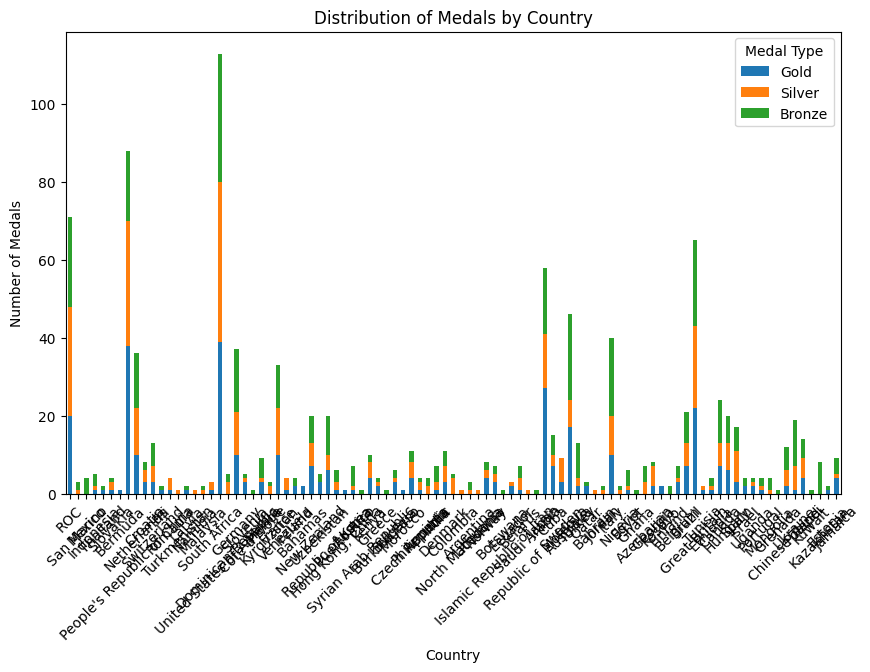

In [0]:
# Plotting the distribution of medals by country
medals_pd.plot(kind='bar', x='MedalCountry', y=['Gold', 'Silver', 'Bronze'], stacked=True, figsize=(10, 6))
plt.title('Distribution of Medals by Country')
plt.xlabel('Country')
plt.ylabel('Number of Medals')
plt.legend(title='Medal Type')
plt.xticks(rotation=45)
plt.show()

##Gender Participation in Different Disciplines (Pie Chart)

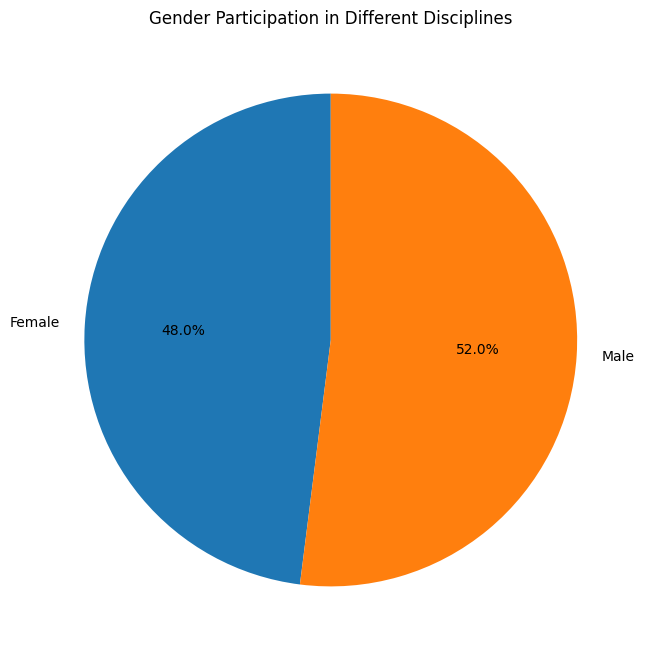

In [0]:
# Plotting gender participation in different disciplines using a pie chart
gender_totals = entries_gender_pd[['Female', 'Male']].sum()
gender_totals.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), startangle=90)
plt.title('Gender Participation in Different Disciplines')
plt.ylabel('')  # Hide the y-label
plt.show()

##Top 10 Countries by Total Medals (Horizontal Bar Chart)

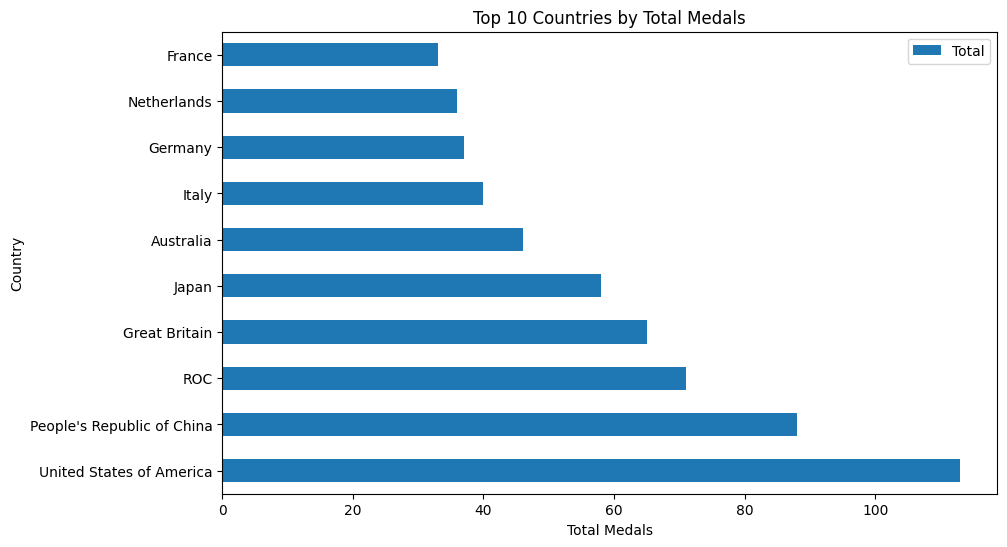

In [0]:
# Plotting top 10 countries by total medals using a horizontal bar chart
top_10_countries = medals_pd.nlargest(10, 'Total')
top_10_countries.plot(kind='barh', x='MedalCountry', y='Total', figsize=(10, 6))
plt.title('Top 10 Countries by Total Medals')
plt.xlabel('Total Medals')
plt.ylabel('Country')
plt.show()

#END